<a href="https://colab.research.google.com/github/nosadchiy/public/blob/main/D_Solar_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D‑Solar plant location (Europe vs China) — decision tree & NPV (3 years)

We compare two sourcing decisions for the next **3 years**:

- **Europe plant** (costs in €): fixed **€1,000,000/year**, variable **€40/panel**, flexible production range 60k–150k (so it can match all demand in this problem).
- **China plant** (costs in Yuan): fixed **8,000,000 Yuan/year**, variable **340 Yuan/panel**, limited production 100k–130k.
  - If demand < 100k, D‑Solar still incurs variable cost for **100k** panels.
  - If demand > 130k, sales are capped at **130k** panels (lost sales above 130k).

**Demand** starts at 100,000 and each year changes by:
- +20% with probability 0.8
- −20% with probability 0.2

**Exchange rate** starts at **9 Yuan/€** and each year:
- Yuan **appreciates** by 10% with probability 0.7
- Yuan **depreciates** by 10% with probability 0.3

> **Key assumption on FX direction** (you can flip it later for sensitivity):  
> “Yuan rises 10%” = **Yuan appreciates**, so **Yuan per euro decreases by 10%** (9 → 8.1).  
> “Yuan drops 10%” = **Yuan depreciates**, so **Yuan per euro increases by 10%** (9 → 9.9).

Discount rate: **10%**. All cash flows accrue at the **beginning** of each year, so year 1 is undiscounted.


In [1]:
import itertools
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


## 1) Model parameters

In [2]:
# Economics
price_eur = 70
D0 = 100_000

# Demand dynamics
d_up, d_down = 1.2, 0.8
p_d_up, p_d_down = 0.8, 0.2

# Discounting (cash flows at beginning of year)
r = 0.10
def discount_factor(year: int) -> float:
    """year = 1,2,3 (beginning of year); year 1 is t=0."""
    return 1 / (1 + r) ** (year - 1)

# Europe plant costs (€)
EU_fixed_eur = 1_000_000
EU_var_eur = 40

# China plant costs (Yuan)
CN_fixed_yuan = 8_000_000
CN_var_yuan = 340

# China production constraints
CN_min_prod = 100_000
CN_max_prod = 130_000

# Exchange rate dynamics (Yuan per euro)
fx0 = 9.0

# Base interpretation: Yuan appreciates => fewer Yuan per euro
fx_mult_appreciate = 0.9   # 9 -> 8.1
fx_mult_depreciate = 1.1   # 9 -> 9.9
p_fx_appreciate = 0.7
p_fx_depreciate = 0.3


## 2) Profit functions (per year)

- Europe: can match demand exactly (all reachable demands are between 64k and 144k, within 60k–150k).
- China: sales and production are capped/floored by its constraints; costs are in Yuan and converted to € using the exchange rate.


In [3]:
def profit_europe_eur(D: float) -> float:
    # produce exactly D
    revenue = price_eur * D
    cost = EU_fixed_eur + EU_var_eur * D
    return revenue - cost

def profit_china_eur(D: float, fx_yuan_per_eur: float) -> float:
    # sales are capped at 130k (lost sales above 130k)
    sales = min(D, CN_max_prod)
    # production is floored at 100k and capped at 130k
    production = max(CN_min_prod, min(D, CN_max_prod))

    revenue = price_eur * sales  # € revenue
    yuan_cost = CN_fixed_yuan + CN_var_yuan * production
    eur_cost = yuan_cost / fx_yuan_per_eur
    return revenue - eur_cost


## 3) Enumerate scenarios for 3 years

Year 1 demand and FX are known (100k, 9 Yuan/€).  
Uncertainty happens from year 1 → year 2 and year 2 → year 3, so there are:

- 2² = 4 demand paths
- 2² = 4 FX paths  
Total **16** joint scenarios (assuming independence).


In [4]:
def enumerate_scenarios_3y(
    fx_mult_up=fx_mult_appreciate,
    fx_mult_down=fx_mult_depreciate
):
    """Return list of (Ds, fxs, prob) for years 1..3."""
    scenarios = []
    # Demand moves for year2 and year3: 1=up, 0=down
    for d_moves in itertools.product([1, 0], repeat=2):
        D = D0
        prob_d = 1.0
        Ds = [D]
        for mv in d_moves:
            if mv == 1:
                D *= d_up
                prob_d *= p_d_up
            else:
                D *= d_down
                prob_d *= p_d_down
            Ds.append(D)

        # FX moves for year2 and year3: 1=appreciate (fx*0.9), 0=depreciate (fx*1.1)
        for fx_moves in itertools.product([1, 0], repeat=2):
            fx = fx0
            prob_fx = 1.0
            fxs = [fx]
            for mv in fx_moves:
                if mv == 1:
                    fx *= fx_mult_up
                    prob_fx *= p_fx_appreciate
                else:
                    fx *= fx_mult_down
                    prob_fx *= p_fx_depreciate
                fxs.append(fx)

            scenarios.append((Ds, fxs, prob_d * prob_fx))
    return scenarios

scenarios = enumerate_scenarios_3y()
len(scenarios), sum(p for _, _, p in scenarios)


(16, 1.0000000000000002)

## 4) Expected NPV for each plant

In [5]:
def npv_europe(Ds):
    return sum(profit_europe_eur(Ds[i]) * discount_factor(i + 1) for i in range(3))

def npv_china(Ds, fxs):
    return sum(profit_china_eur(Ds[i], fxs[i]) * discount_factor(i + 1) for i in range(3))

exp_npv_eu = 0.0
exp_npv_cn = 0.0

rows = []
for Ds, fxs, p in scenarios:
    npv_eu = npv_europe(Ds)
    npv_cn = npv_china(Ds, fxs)
    exp_npv_eu += p * npv_eu
    exp_npv_cn += p * npv_cn
    rows.append({
        "Demand path (Y1,Y2,Y3)": tuple(int(x) for x in Ds),
        "FX path (Y1,Y2,Y3) Yuan/€": tuple(round(x, 4) for x in fxs),
        "Scenario prob": p,
        "NPV Europe (€)": npv_eu,
        "NPV China (€)": npv_cn,
    })

summary = pd.DataFrame({
    "Plant": ["Europe", "China"],
    "Expected NPV (€, 3y)": [exp_npv_eu, exp_npv_cn],
    "Difference vs best (€, 3y)": [exp_npv_eu - max(exp_npv_eu, exp_npv_cn),
                                  exp_npv_cn - max(exp_npv_eu, exp_npv_cn)]
})
summary


,Plant,"Expected NPV (€, 3y)","Difference vs best (€, 3y)"
0,Europe,6.429091e+06,0.000000
1,China,6.247497e+06,-181593.849843


### Recommendation (under the FX assumption stated above)

In [6]:
best = "Europe" if exp_npv_eu >= exp_npv_cn else "China"
delta = abs(exp_npv_eu - exp_npv_cn)

print(f"Expected NPV (Europe): €{exp_npv_eu:,.0f}")
print(f"Expected NPV (China) : €{exp_npv_cn:,.0f}")
print(f"Recommended plant    : {best} (advantage ≈ €{delta:,.0f} over 3 years)")


Expected NPV (Europe): €6,429,091
Expected NPV (China) : €6,247,497
Recommended plant    : Europe (advantage ≈ €181,594 over 3 years)


## 5) Sensitivity: if you interpret “Yuan rises 10%” differently

Some courses/texts loosely say “the Yuan rises” meaning the **number of Yuan per euro rises**.  
That is the *opposite* direction. Below we compute that alternative too.


In [7]:
# Alternative interpretation: "Yuan rises 10%" => fx increases 10% (more Yuan per €)
# (This makes euro-denominated costs LOWER when fx increases, since we divide by a larger number.)

scenarios_alt = enumerate_scenarios_3y(fx_mult_up=1.1, fx_mult_down=0.9)

exp_alt_cn = 0.0
for Ds, fxs, p in scenarios_alt:
    exp_alt_cn += p * npv_china(Ds, fxs)

print(f"China expected NPV under alternative FX interpretation: €{exp_alt_cn:,.0f}")
print(f"Europe expected NPV (unchanged):                         €{exp_npv_eu:,.0f}")
print(f"Recommended under alternative FX interpretation: {'China' if exp_alt_cn>exp_npv_eu else 'Europe'}")


China expected NPV under alternative FX interpretation: €7,362,191
Europe expected NPV (unchanged):                         €6,429,091
Recommended under alternative FX interpretation: China


## 6) Build and visualize the decision tree

We draw a tree with:
- a **decision node** (Europe vs China),
- then **chance nodes** for demand and FX updates for year 2 and year 3,
- leaf nodes showing the **scenario probability** and the **scenario NPV** (for the selected plant).

To avoid an unreadable plot, the visualization uses compact labels and a tree layout.


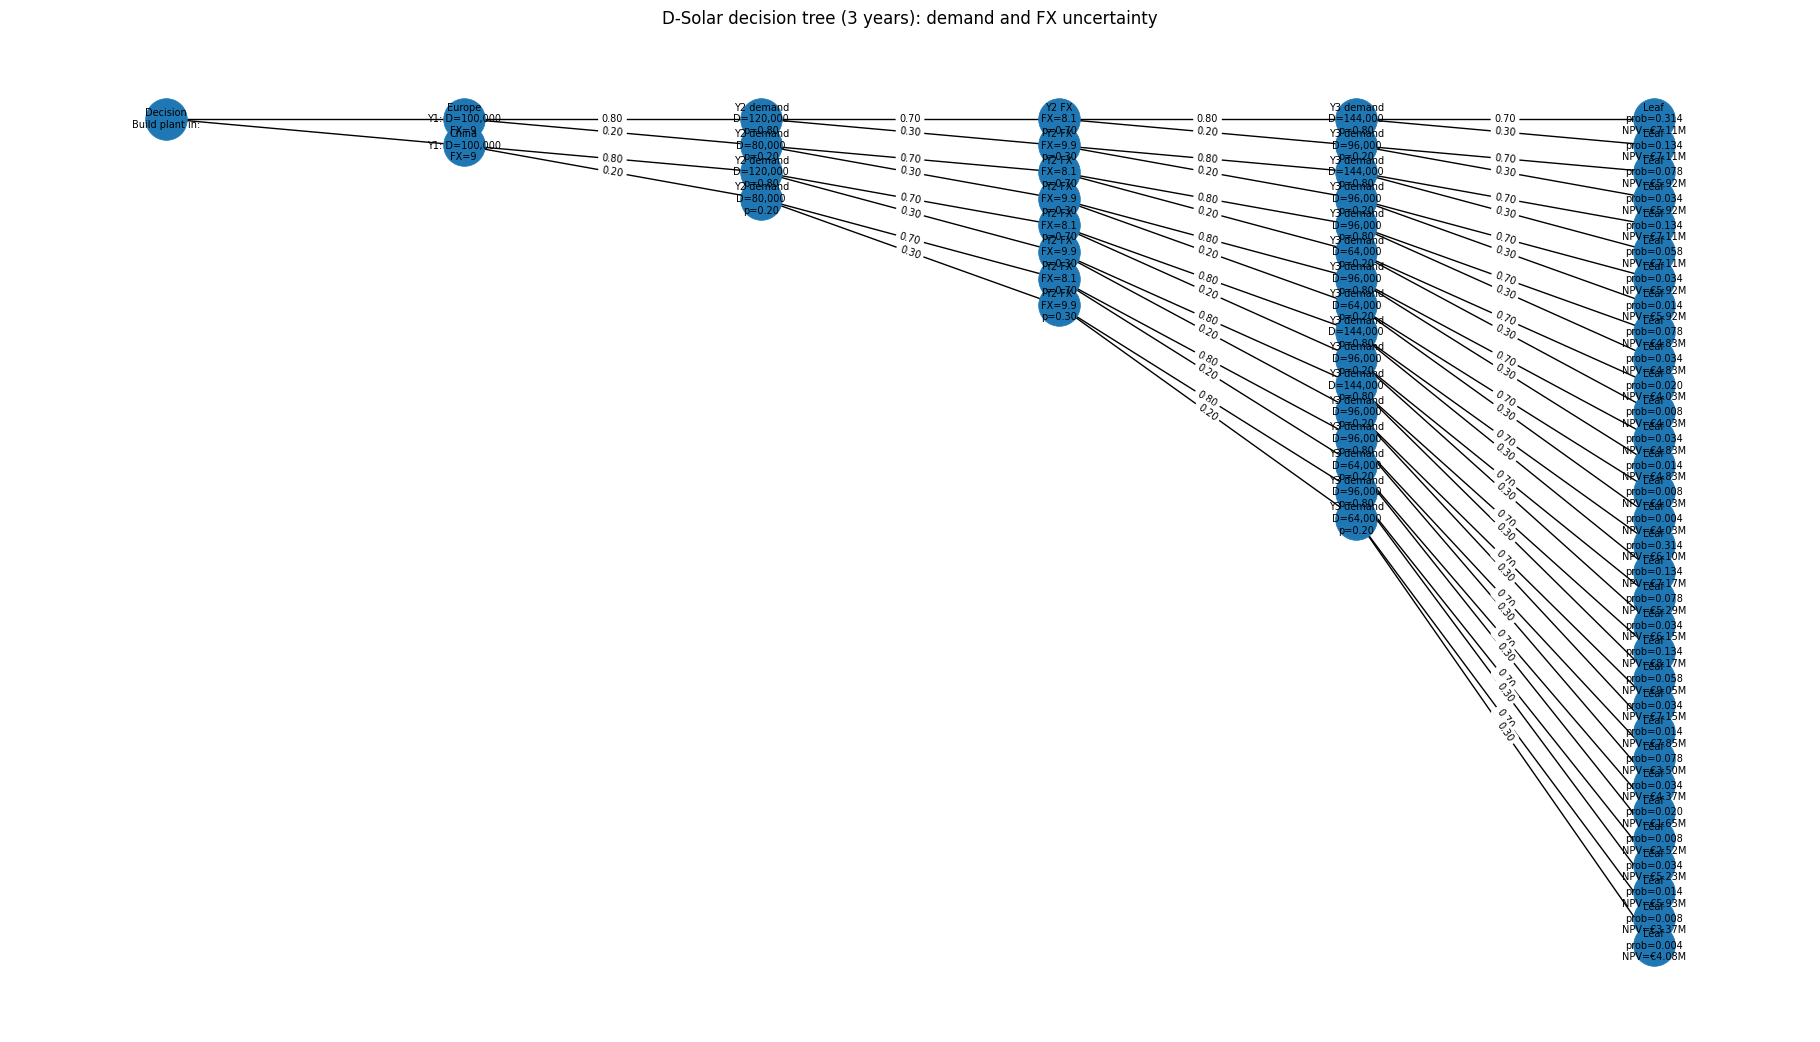

In [8]:
def build_tree_for_plant(plant: str, fx_mult_up=fx_mult_appreciate, fx_mult_down=fx_mult_depreciate):
    """Return a NetworkX DiGraph representing the 3-year tree for a given plant."""
    assert plant in {"Europe", "China"}

    # Enumerate scenarios and also construct nodes along the way
    # We'll build a sequential tree: Year2 demand -> Year2 FX -> Year3 demand -> Year3 FX (leaf)
    G = nx.DiGraph()

    root = f"{plant}|Y1"
    G.add_node(root, label=f"{plant}\nY1: D={int(D0):,}\nFX={fx0:g}")

    # Helpers
    def demand_next(D, up): return D * (d_up if up else d_down)
    def fx_next(fx, app): return fx * (fx_mult_up if app else fx_mult_down)

    # Expand tree
    for d2_up in [True, False]:
        D2 = demand_next(D0, d2_up)
        p_d2 = p_d_up if d2_up else p_d_down
        n_d2 = f"{plant}|Y2D|{'U' if d2_up else 'D'}"
        G.add_node(n_d2, label=f"Y2 demand\nD={int(D2):,}\np={p_d2:.2f}")
        G.add_edge(root, n_d2, prob=p_d2)

        for fx2_app in [True, False]:
            fx2 = fx_next(fx0, fx2_app)
            p_fx2 = p_fx_appreciate if fx2_app else p_fx_depreciate
            n_fx2 = f"{plant}|Y2FX|{'A' if fx2_app else 'D'}|{'U' if d2_up else 'D'}"
            G.add_node(n_fx2, label=f"Y2 FX\nFX={fx2:.3g}\np={p_fx2:.2f}")
            G.add_edge(n_d2, n_fx2, prob=p_fx2)

            for d3_up in [True, False]:
                D3 = demand_next(D2, d3_up)
                p_d3 = p_d_up if d3_up else p_d_down
                n_d3 = f"{plant}|Y3D|{'U' if d3_up else 'D'}|{fx2_app}|{d2_up}"
                G.add_node(n_d3, label=f"Y3 demand\nD={int(D3):,}\np={p_d3:.2f}")
                G.add_edge(n_fx2, n_d3, prob=p_d3)

                for fx3_app in [True, False]:
                    fx3 = fx_next(fx2, fx3_app)
                    p_fx3 = p_fx_appreciate if fx3_app else p_fx_depreciate
                    n_leaf = f"{plant}|LEAF|{d2_up}|{fx2_app}|{d3_up}|{fx3_app}"

                    Ds = [D0, D2, D3]
                    fxs = [fx0, fx2, fx3]
                    prob = p_d2 * p_fx2 * p_d3 * p_fx3

                    if plant == "Europe":
                        npv = npv_europe(Ds)
                    else:
                        npv = npv_china(Ds, fxs)

                    G.add_node(
                        n_leaf,
                        label=f"Leaf\nprob={prob:.3f}\nNPV=€{npv/1e6:.2f}M"
                    )
                    G.add_edge(n_d3, n_leaf, prob=p_fx3)
    return G, root

def tree_layout(G, root):
    """Simple layered layout by topological depth."""
    depths = {root: 0}
    for u in nx.topological_sort(G):
        for v in G.successors(u):
            depths[v] = depths[u] + 1

    layers = {}
    for n, d in depths.items():
        layers.setdefault(d, []).append(n)

    pos = {}
    for d in sorted(layers):
        layer = layers[d]
        for i, n in enumerate(layer):
            pos[n] = (d, -i)  # x=depth, y=stack
    return pos

# Build a combined tree: decision node -> each plant subtree
G_dec = nx.DiGraph()
decision = "DECISION"
G_dec.add_node(decision, label="Decision\nBuild plant in:")

G_eu, root_eu = build_tree_for_plant("Europe")
G_cn, root_cn = build_tree_for_plant("China")

# Merge graphs
G_dec = nx.compose(G_dec, G_eu)
G_dec = nx.compose(G_dec, G_cn)

G_dec.add_edge(decision, root_eu, prob=None)
G_dec.add_edge(decision, root_cn, prob=None)

pos = tree_layout(G_dec, decision)

# Plot
plt.figure(figsize=(18, 10))
labels = {n: G_dec.nodes[n].get("label", n) for n in G_dec.nodes}
nx.draw(G_dec, pos, with_labels=False, arrows=False, node_size=900, linewidths=0.5)
nx.draw_networkx_labels(G_dec, pos, labels=labels, font_size=7)

# Edge probability labels (skip decision edges)
edge_labels = {}
for u, v, data in G_dec.edges(data=True):
    if data.get("prob") is not None:
        edge_labels[(u, v)] = f"{data['prob']:.2f}"
nx.draw_networkx_edge_labels(G_dec, pos, edge_labels=edge_labels, font_size=7)

plt.axis("off")
plt.title("D‑Solar decision tree (3 years): demand and FX uncertainty")
plt.show()


## 7) (Optional) Show a few scenarios in a table

In [9]:
df_scen = pd.DataFrame(rows).sort_values("Scenario prob", ascending=False).reset_index(drop=True)
df_scen.head(8)


,"Demand path (Y1,Y2,Y3)","FX path (Y1,Y2,Y3) Yuan/€",Scenario prob,NPV Europe (€),NPV China (€)
0,"(100000, 120000, 144000)","(9.0, 8.1, 7.29)",0.3136,7.107438e+06,6.095602e+06
1,"(100000, 120000, 144000)","(9.0, 8.1, 8.91)",0.1344,7.107438e+06,7.171559e+06
2,"(100000, 120000, 144000)","(9.0, 9.9, 8.91)",0.1344,7.107438e+06,8.167376e+06
3,"(100000, 120000, 96000)","(9.0, 8.1, 7.29)",0.0784,5.917355e+06,5.285005e+06
4,"(100000, 80000, 96000)","(9.0, 8.1, 7.29)",0.0784,4.826446e+06,3.502738e+06
5,"(100000, 120000, 144000)","(9.0, 9.9, 10.89)",0.0576,7.107438e+06,9.047705e+06
6,"(100000, 120000, 96000)","(9.0, 9.9, 8.91)",0.0336,5.917355e+06,7.146534e+06
7,"(100000, 120000, 96000)","(9.0, 8.1, 8.91)",0.0336,5.917355e+06,6.150717e+06
